<a href="https://colab.research.google.com/github/william-engel/JetsonNano/blob/main/Jetson_Nano_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Jetson Nano Object Detection

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
resnet = ResNet50(include_top = True, weights = 'imagenet')

In [3]:
# https://www.tensorflow.org/hub/tutorials/tf2_object_detection
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [4]:
IMAGES_FOR_TEST = {
  'Husky' : 'https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630',
  'Bird'  : 'https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg',
  'Monkey': 'https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg',
  'Snake' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Eastern_Indigo_Snake.jpg/1024px-Eastern_Indigo_Snake.jpg'
}

In [5]:
def create_resnet():
  input = tf.keras.Input(shape = (None, None, 3), dtype = tf.uint8) # take varying input
  x = tf.cast(input, dtype = tf.float32) # tensorflow expects float32
  x = preprocess_input(x)
  x = resnet(x)
  model = tf.keras.Model(inputs = [input], outputs = [x])
  return model

In [6]:
model = create_resnet()
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
_________________________________________________________________
None


In [7]:
prediction = model.predict(load_image_into_numpy_array(IMAGES_FOR_TEST['Bird']))

In [8]:
print(decode_predictions(prediction, top = 3))

[[('n01828970', 'bee_eater', 0.11329551), ('n01833805', 'hummingbird', 0.07099917), ('n01537544', 'indigo_bunting', 0.06105295)]]


In [56]:
import time
INPUT_SHAPE = (244,244)
def preprocess_images(image_dict):
  image_batch = None

  for key, val in image_dict.items():
    img = load_image_into_numpy_array(val)
    img = tf.image.resize(img, INPUT_SHAPE)
    if image_batch is None:
      image_batch = img 
    else:
      image_batch = tf.concat([image_batch, img], axis = 0)
  return tf.cast(image_batch, tf.uint8)


In [57]:
image_batch = preprocess_images(IMAGES_FOR_TEST)

In [58]:
prediction_batch = model.predict(image_batch)
print(decode_predictions(prediction_batch, top = 1)[0][0])


('n02110185', 'Siberian_husky', 0.5441508)


### Inference with native TF2.0 saved model

In [61]:
def plot_images_and_predictions(image_batch, prediction_batch):
  prediction_batch = decode_predictions(prediction_batch, top = 1)

  plt.figure(figsize = (10,7))
  for index, (image, prediction) in enumerate(zip(image_batch, prediction_batch)):
    plt.subplot(2, 2, index + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(prediction[0][1])


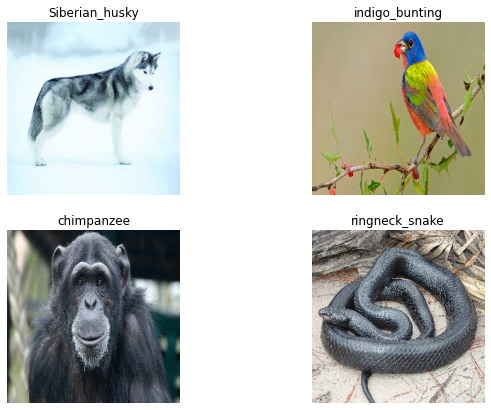

In [62]:
plot_images_and_predictions(image_batch, prediction_batch)

In [63]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

#Inference with native TF2.0 saved model

In [64]:
model = tf.keras.models.load_model('resnet50_saved_model')

In [65]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
batch_size = image_batch.shape[0]
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(image_batch)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(image_batch)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 43.4ms
Step 50: 44.9ms
Step 100: 46.1ms
Step 150: 46.4ms
Step 200: 47.3ms
Step 250: 46.2ms
Step 300: 46.6ms
Step 350: 45.5ms
Step 400: 46.9ms
Step 450: 44.7ms
Step 500: 44.9ms
Step 550: 46.2ms
Step 600: 46.3ms
Step 650: 44.9ms
Step 700: 45.7ms
Step 750: 44.9ms
Step 800: 44.3ms
Step 850: 44.7ms
Step 900: 44.5ms
Step 950: 44.2ms
Throughput: 88 images/s


### TF-TRT FP32 model

We first convert the TF native FP32 model to a TF-TRT FP32 model.

Let's try: **from tensorflow.experimental import tensorrt**

In [67]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [75]:
# print supported precision modes
print(trt.TrtPrecisionMode.supported_precision_modes())

['FP32', 'FP16', 'INT8', 'fp32', 'fp16', 'int8']


In [110]:
from tensorflow.experimental import tensorrt

In [87]:
# check available GPU
# Tesla T4 16GB 
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

TRT_MAX_WORKSPACE_SIZE_BYTES = int(8e9) # 8 GB

In [88]:
conversion_params = tensorrt.ConversionParams(
    rewriter_config_template=None, 
    max_workspace_size_bytes= TRT_MAX_WORKSPACE_SIZE_BYTES, # integer, maximum GPU memory size available for TensorRT in Bytes (1GB = 1 000 000 000)
    precision_mode='FP32',                                  # string, allowed values 'FP32', 'FP16' or 'INT8'
    minimum_segment_size=3,                                 # the minimum number of nodes required for a subgraph to be replaced by TRTEngineOp
    is_dynamic_op=True,                                     # Dynamic mode allows you to have unknown shapes in your model by building during runtime.
                                                            # For example, you may have an image classification network that works on images of any
                                                            # size where the input placeholder has the shape [?, ?, ?, 3]. 
                                                            # If you were to first send a batch of images to the model with shape [8, 224, 224, 3],
                                                            # a new TensorRT engine will be created that is optimized for those dimensions
    maximum_cached_engines=1, 
    use_calibration=True,                                   # this argument is ignored if precision_mode is not INT8.
    max_batch_size=1,                                       # max size for the input batch. 
    allow_build_at_runtime=True
)

In [89]:
converter = tensorrt.Converter(input_saved_model_dir = 'resnet50_saved_model',
                               conversion_params = conversion_params)

In [90]:
converter.convert()

In [91]:
converter.save(output_saved_model_dir = 'resnet50_saved_model_TFTRT_FP32')

In [111]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_UINT8
        shape: (-1, -1, -1, 3)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['resnet50'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/

In [108]:
model = tf.keras.models.load_model('resnet50_saved_model_TFTRT_FP32')
infer = model.signatures['serving_default'] # model for inference

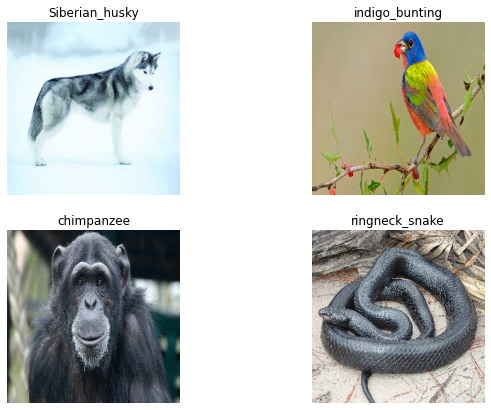

In [109]:
prediction_batch = infer(image_batch) # output is a dictionary # no .predict function
plot_images_and_predictions(image_batch, prediction_batch['resnet50'].numpy())

In [112]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
batch_size = image_batch.shape[0]
elapsed_time = []

for i in range(N_warmup_run):
  preds = infer(image_batch)

for i in range(N_run):
  start_time = time.time()
  preds = infer(image_batch)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 17.1ms
Step 50: 17.4ms
Step 100: 17.5ms
Step 150: 17.5ms
Step 200: 17.5ms
Step 250: 17.5ms
Step 300: 17.5ms
Step 350: 17.5ms
Step 400: 17.5ms
Step 450: 17.6ms
Step 500: 17.6ms
Step 550: 17.6ms
Step 600: 17.6ms
Step 650: 17.7ms
Step 700: 17.6ms
Step 750: 17.7ms
Step 800: 17.7ms
Step 850: 17.7ms
Step 900: 17.8ms
Step 950: 17.8ms
Throughput: 227 images/s


### TF-TRT FP16 model
We next convert the native TF FP32 saved model to TF-TRT FP16 model.

Let's try: **from tensorflow.python.compiler.tensorrt import trt_convert as trt**

In [113]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [142]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params._replace(precision_mode = trt.TrtPrecisionMode.FP16,
                           max_workspace_size_bytes = int(8e9))

print(trt.DEFAULT_TRT_MAX_WORKSPACE_SIZE_BYTES) # ~ 10GB

1073741824


In [143]:
converter = trt.TrtGraphConverterV2(input_saved_model_dir = 'resnet50_saved_model',
                                    conversion_params = conversion_params)

In [144]:
converter.convert()

In [145]:
converter.save(output_saved_model_dir = 'resnet50_saved_model_TFTRT_FP16')

In [146]:
model = tf.keras.models.load_model('resnet50_saved_model_TFTRT_FP16')

In [147]:
print(model.signatures.keys())

KeysView(_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(input_2) at 0x7FC6322C29E8>}))


In [148]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP16


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_UINT8
        shape: (-1, -1, -1, 3)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['resnet50'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/

In [149]:
infer = model.signatures['serving_default']

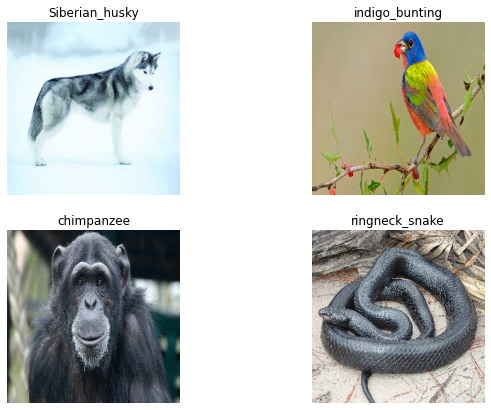

In [150]:
prediction_batch = infer(image_batch) # output is a dictionary # no .predict function
plot_images_and_predictions(image_batch, prediction_batch['resnet50'].numpy())

In [151]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
batch_size = image_batch.shape[0]
elapsed_time = []

for i in range(N_warmup_run):
  preds = infer(image_batch)

for i in range(N_run):
  start_time = time.time()
  preds = infer(image_batch)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 16.6ms
Step 50: 16.8ms
Step 100: 16.8ms
Step 150: 16.8ms
Step 200: 16.8ms
Step 250: 16.8ms
Step 300: 16.8ms
Step 350: 16.8ms
Step 400: 16.9ms
Step 450: 16.8ms
Step 500: 16.9ms
Step 550: 16.9ms
Step 600: 16.9ms
Step 650: 16.9ms
Step 700: 16.9ms
Step 750: 16.9ms
Step 800: 16.9ms
Step 850: 16.9ms
Step 900: 16.9ms
Step 950: 16.9ms
Throughput: 237 images/s


### TF-TRT INT8 model

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.  

In [152]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [153]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode = trt.TrtPrecisionMode.INT8,
    max_workspace_size_bytes = int(8e9),
    use_calibration = True
)

In [154]:
converter = trt.TrtGraphConverterV2(input_saved_model_dir = 'resnet50_saved_model',
                                    conversion_params = conversion_params)

In [156]:
def calibration_input_fn():
  yield (image_batch,)

converter.convert(calibration_input_fn = calibration_input_fn)

In [157]:
converter.save(output_saved_model_dir = 'resnet50_saved_model_TFTRT_INT8')

In [159]:
model = tf.keras.models.load_model('resnet50_saved_model_TFTRT_INT8')
print(model.signatures.keys())

KeysView(_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(input_2) at 0x7FC628553828>}))


In [160]:
infer = model.signatures['serving_default']

In [161]:
prediction_batch = infer(image_batch)

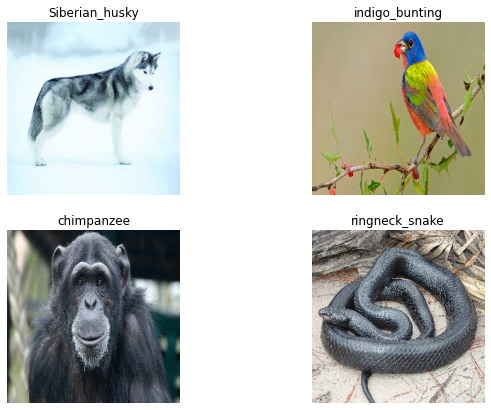

In [163]:
plot_images_and_predictions(image_batch, prediction_batch['resnet50'].numpy())

In [164]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
batch_size = image_batch.shape[0]
elapsed_time = []

for i in range(N_warmup_run):
  preds = infer(image_batch)

for i in range(N_run):
  start_time = time.time()
  preds = infer(image_batch)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 16.2ms
Step 50: 16.7ms
Step 100: 16.7ms
Step 150: 16.6ms
Step 200: 16.6ms
Step 250: 16.6ms
Step 300: 16.7ms
Step 350: 16.7ms
Step 400: 16.7ms
Step 450: 16.7ms
Step 500: 16.7ms
Step 550: 16.7ms
Step 600: 16.8ms
Step 650: 16.8ms
Step 700: 16.8ms
Step 750: 16.8ms
Step 800: 16.8ms
Step 850: 16.8ms
Step 900: 16.8ms
Step 950: 16.9ms
Throughput: 239 images/s


# Best Practives

**Conversion on the target machine**

You need to execute the conversion on the machine on which you will run inference. This is because TensorRT optimizes the graph by using the available GPUs and thus the optimized graph may not perform well on a different GPU.

**Batch normalization**

The FusedBatchNorm operator is supported, which means this operator is converted to the relevant TensorRT batch normalization layers. This operator has an argument named is_training which is a boolean to indicate whether the operation is for training or inference. The operator is converted to TensorRT only if is_training=False.
When converting a model from Keras, ensure you call the function **keras.backend.set_learning_phase(0)** to ensure that your batch normalization layers are built in inference mode and therefore are eligible to be converted. We recommend to call this function at the very beginning of your Python script, right after import keras.

from official tensorflow website:

THIS FUNCTION IS DEPRECATED. It will be removed after 2020-10-11. Instructions for updating: Simply pass a True/False value to the training argument of the __call__ method of your layer or model.